In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

In [163]:
# Create a dict object where keys are 'str' and values are 'pandas DataFrame'

crypto = {}

crypto["bitcoin"] = pd.read_csv("./data/bitcoin_price.csv")
crypto["bitcoin_cash"] = pd.read_csv("./data/bitcoin_cash_price.csv")
crypto["dash"] = pd.read_csv("./data/dash_price.csv")
crypto["ethereum"] = pd.read_csv("./data/ethereum_price.csv")
crypto["iota"] = pd.read_csv("./data/iota_price.csv")
crypto["litecoin"] = pd.read_csv("./data/litecoin_price.csv")
crypto["monero"] = pd.read_csv("./data/monero_price.csv")
crypto["nem"] = pd.read_csv("./data/nem_price.csv")
crypto["neo"] = pd.read_csv("./data/neo_price.csv")
crypto["numeraire"] = pd.read_csv("./data/numeraire_price.csv")
crypto["ripple"] = pd.read_csv("./data/ripple_price.csv")
crypto["stratis"] = pd.read_csv("./data/stratis_price.csv")
crypto["waves"] = pd.read_csv("./data/waves_price.csv")

In [164]:
crypto

{'bitcoin':               Date     Open     High      Low    Close         Volume  \
 0     Sep 05, 2017  4228.29  4427.84  3998.11  4376.53  2,697,970,000   
 1     Sep 04, 2017  4591.63  4591.63  4108.40  4236.31  2,987,330,000   
 2     Sep 03, 2017  4585.27  4714.08  4417.59  4582.96  1,933,190,000   
 3     Sep 02, 2017  4901.42  4975.04  4469.24  4578.77  2,722,140,000   
 4     Sep 01, 2017  4701.76  4892.01  4678.53  4892.01  2,599,080,000   
 ...            ...      ...      ...      ...      ...            ...   
 1587  May 02, 2013   116.38   125.60    92.28   105.21              -   
 1588  May 01, 2013   139.00   139.89   107.72   116.99              -   
 1589  Apr 30, 2013   144.00   146.93   134.05   139.00              -   
 1590  Apr 29, 2013   134.44   147.49   134.00   144.54              -   
 1591  Apr 28, 2013   135.30   135.98   132.10   134.21              -   
 
           Market Cap  
 0     69,954,400,000  
 1     75,955,500,000  
 2     75,841,700,000  
 3 

In [165]:
crypto["bitcoin"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1592 non-null   object 
 1   Open        1592 non-null   float64
 2   High        1592 non-null   float64
 3   Low         1592 non-null   float64
 4   Close       1592 non-null   float64
 5   Volume      1592 non-null   object 
 6   Market Cap  1592 non-null   object 
dtypes: float64(4), object(3)
memory usage: 87.2+ KB


In [166]:
# Clean data
for coin in crypto:
    crypto[coin] = crypto[coin].drop(["Open", "High", "Low", "Volume", "Market Cap"], axis=1)
    crypto[coin]["Date"] = pd.to_datetime(crypto[coin]["Date"])
    crypto[coin] = crypto[coin].set_index("Date")
    crypto[coin] = crypto[coin].sort_values("Date")
crypto["bitcoin"]

,Close
Date,
2013-04-28,134.21
2013-04-29,144.54
2013-04-30,139.00
2013-05-01,116.99
2013-05-02,105.21
...,...
2017-09-01,4892.01
2017-09-02,4578.77
2017-09-03,4582.96


In [167]:
# Delete new coins
del crypto["bitcoin_cash"], crypto["numeraire"], crypto["iota"]

In [168]:
# Only get the last 350 days
for coin in crypto:
    crypto[coin] = crypto[coin][-350:]

In [169]:
# Create pct change dataframe
for coin in crypto:
    crypto[coin]["ClosePctChg"] = crypto[coin]["Close"].pct_change().fillna(0)

crypto["bitcoin"]

/tmp/ipykernel_3718/1569916204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto[coin]["ClosePctChg"] = crypto[coin]["Close"].pct_change().fillna(0)


,Close,ClosePctChg
Date,,
2016-09-21,597.15,0.000000
2016-09-22,596.30,-0.001423
2016-09-23,602.84,0.010968
2016-09-24,602.63,-0.000348
2016-09-25,600.83,-0.002987
...,...,...
2017-09-01,4892.01,0.040103
2017-09-02,4578.77,-0.064031
2017-09-03,4582.96,0.000915


In [170]:
# Make a new pct change dataframe
pctchgdf = pd.DataFrame(index=crypto["bitcoin"].index)  # index is same for all anyway
for coin in crypto:
    pctchgdf[coin] = crypto[coin]["ClosePctChg"]

pctchgdf

,bitcoin,dash,ethereum,litecoin,monero,nem,neo,ripple,stratis,waves
Date,,,,,,,,,,
2016-09-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-09-22,-0.001423,0.000867,-0.037763,-0.018229,0.024194,-0.021422,-0.168111,0.002050,-0.014046,-0.017668
2016-09-23,0.010968,0.000000,0.006038,0.010610,0.060039,-0.009058,-0.037535,0.053778,0.030755,-0.047749
2016-09-24,-0.000348,-0.000867,-0.033758,0.000000,-0.012999,-0.015997,-0.120845,0.020940,0.093678,-0.027708
2016-09-25,-0.002987,0.001735,0.017081,0.000000,-0.036689,-0.019547,-0.069439,0.066965,-0.070623,-0.035970
...,...,...,...,...,...,...,...,...,...,...
2017-09-01,0.040103,0.039728,0.012270,0.210808,0.005626,-0.014540,-0.034680,-0.027974,-0.004121,-0.033670
2017-09-02,-0.064031,-0.109775,-0.099964,-0.081590,-0.116147,-0.109615,-0.009060,-0.087774,-0.125517,-0.088850
2017-09-03,0.000915,0.017763,-0.004298,-0.027588,0.009696,0.038461,-0.044136,0.009450,0.039432,-0.005736


<AxesSubplot:xlabel='Date'>

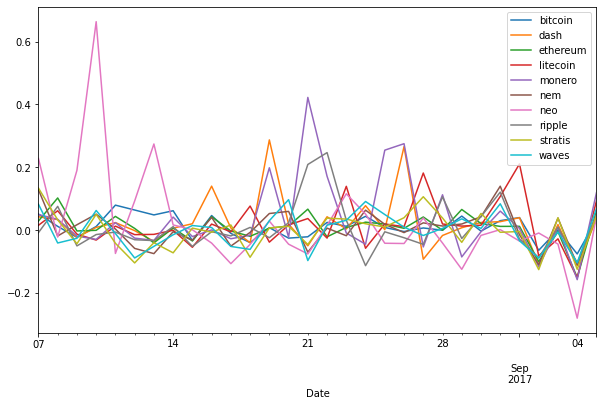

In [171]:
# Plot last 30 days easily as a method of dataframe
pctchgdf[-30:].plot(figsize=(10, 6))

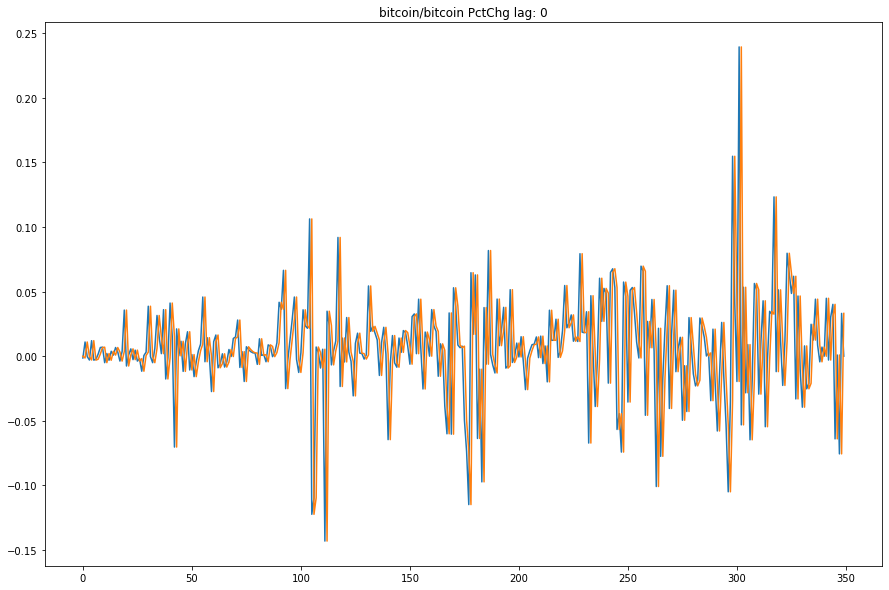

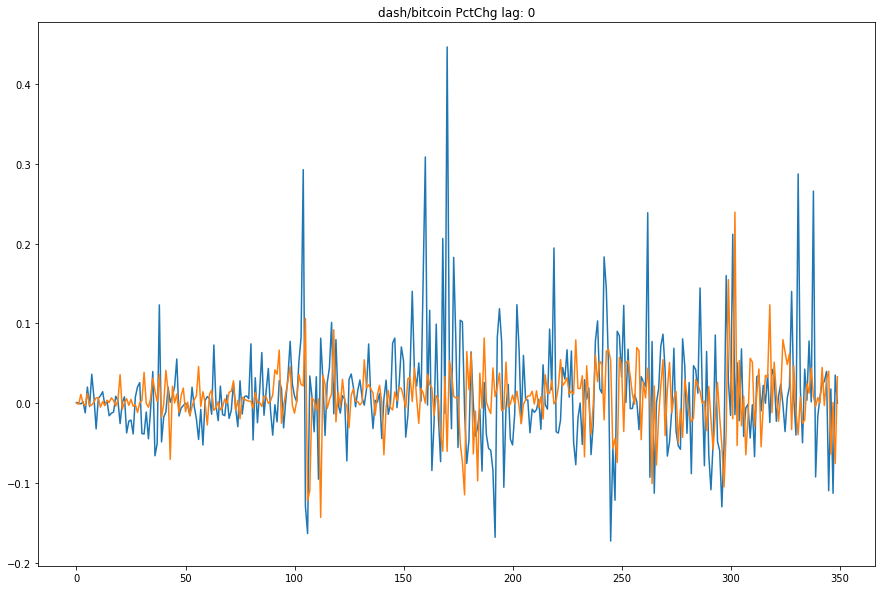

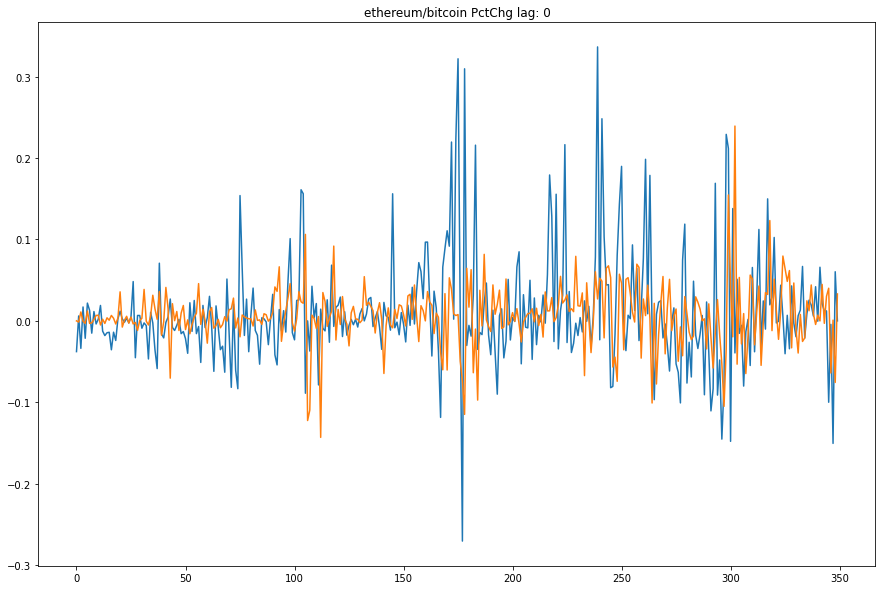

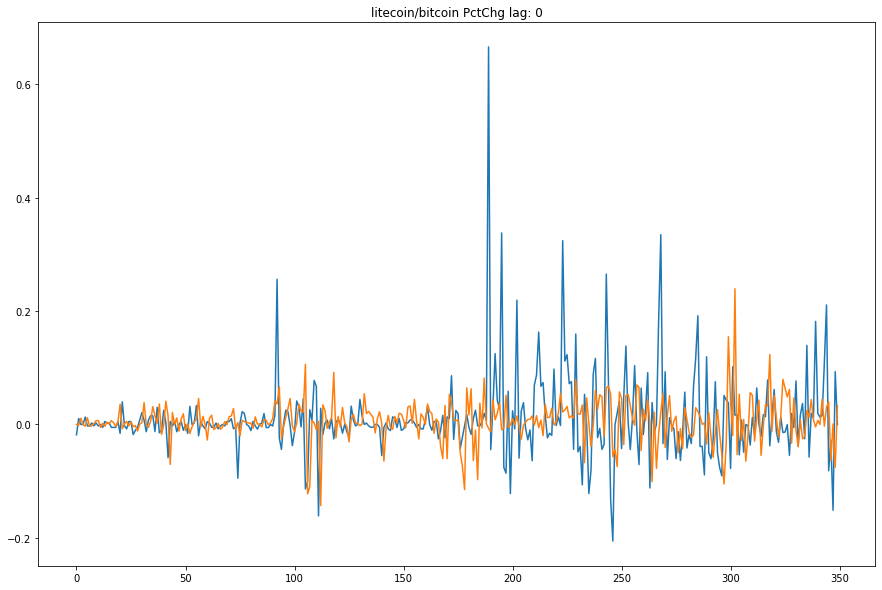

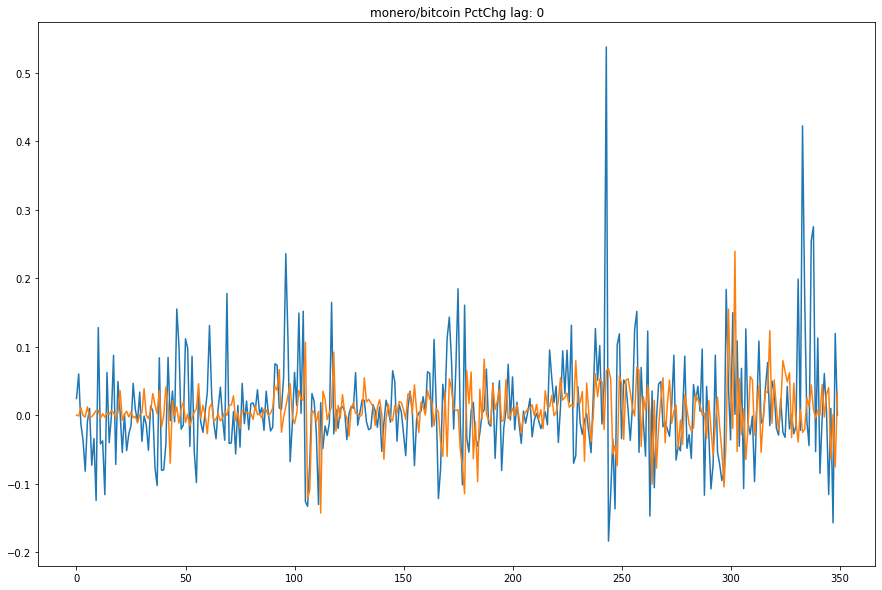

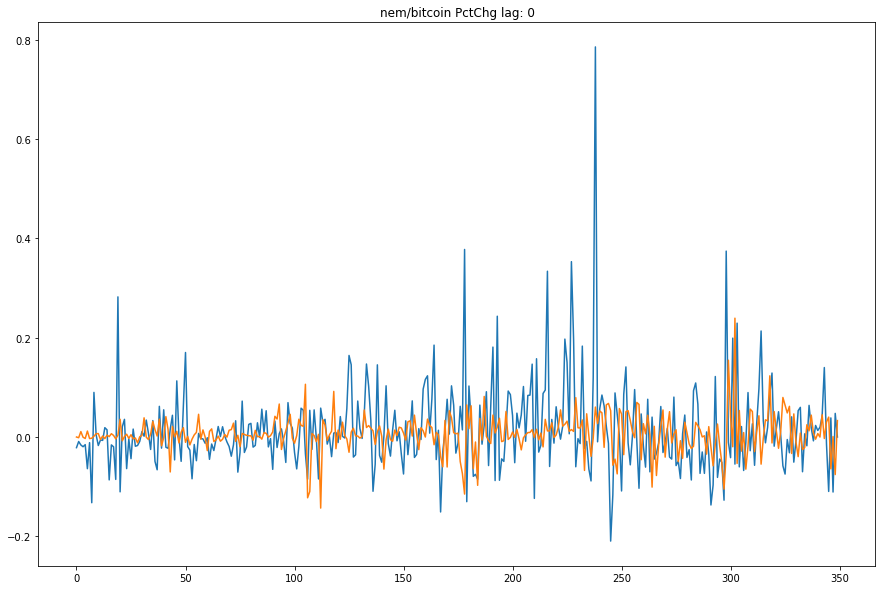

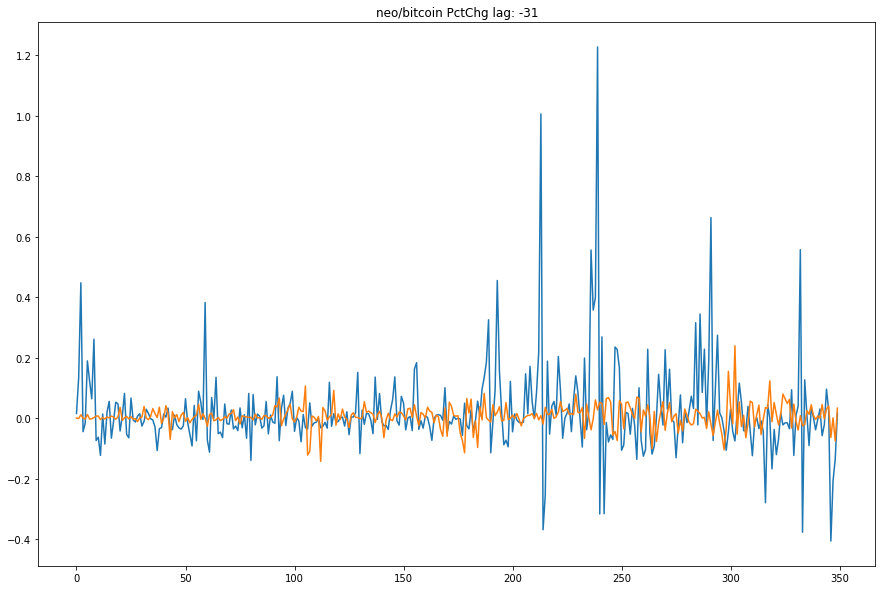

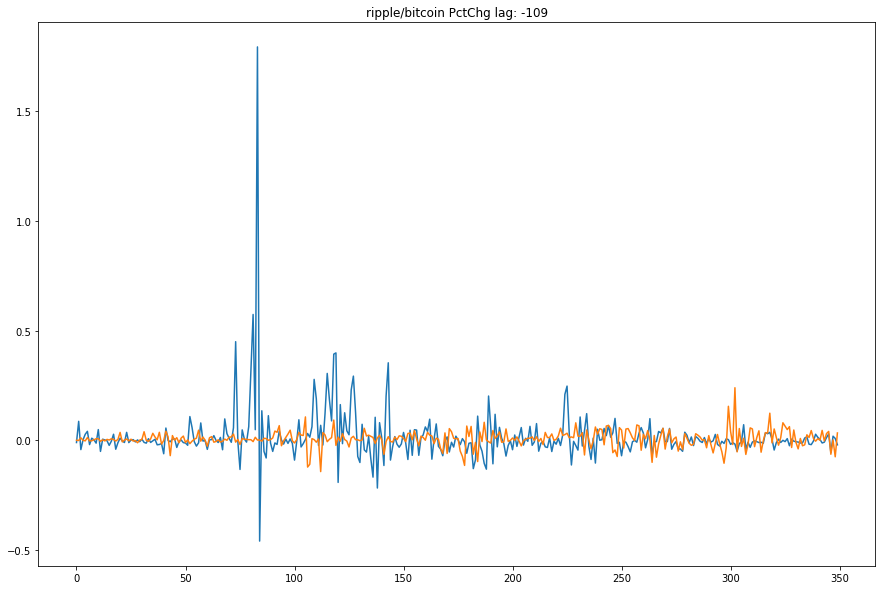

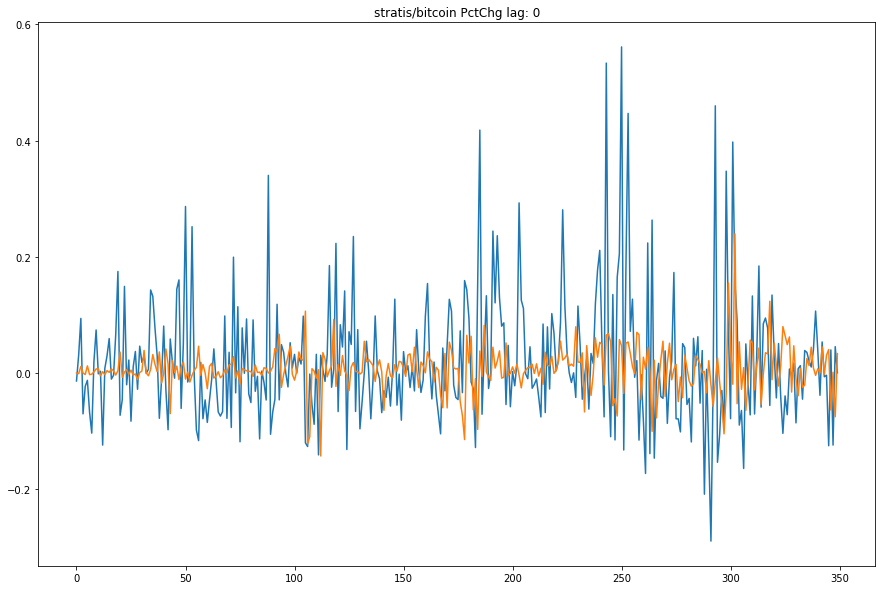

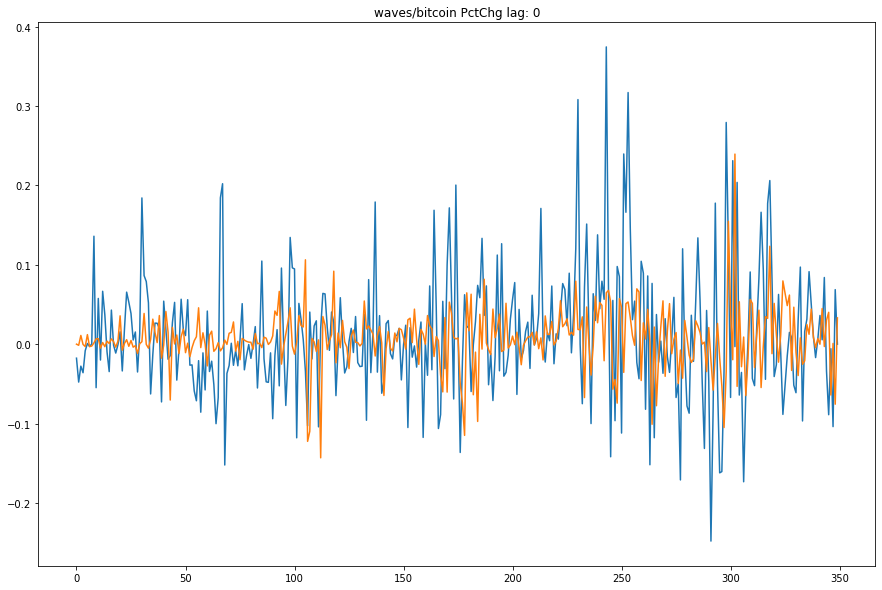

In [172]:
corrBitcoin = {}
corrDF = pd.DataFrame()

for coin in crypto:
    corrBitcoin[coin] = correlate(crypto[coin]["ClosePctChg"], crypto["bitcoin"]["ClosePctChg"])
    lag = np.argmax(corrBitcoin[coin])
    laggedCoin = np.roll(crypto[coin]["ClosePctChg"], shift=int(np.ceil(lag)))
    corrDF[coin] = laggedCoin

    plt.figure(figsize=(15, 10))
    plt.plot(laggedCoin)
    plt.plot(crypto["bitcoin"]["ClosePctChg"].values)
    title = coin + "/bitcoin PctChg lag: " + str(lag - 349)
    plt.title(title)

    plt.show()